In [114]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV, SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_df = pd.read_csv("phishing_url_train.csv")
test_df = pd.read_csv("phishing_url_test.csv")

In [ ]:
if 'url' in train_df.columns:
    train_df.drop(columns=['url'], inplace=True)
if 'url' in test_df.columns:
    test_df.drop(columns=['url'], inplace=True)


In [ ]:
status_map = {'legitimate': 0, 'phishing': 1}
train_df["status"] = train_df["status"].map(status_map)
test_df["status"] = test_df["status"].map(status_map)


In [ ]:
url_based_features = [
    "length_url",
    "length_hostname",
    "nb_dots",
    "nb_hyphens",
    "nb_at",
    "nb_qm",
    "nb_eq",
    "nb_underscore",
    "nb_percent",
    "nb_slash",
    "nb_www",
    "nb_com",
    "https_token",
    "ratio_digits_url",
    "ratio_digits_host",
    "tld_in_subdomain",
    "prefix_suffix",
    "random_domain",
    "shortening_service",
    "nb_redirection",
    "length_words_raw",
    "char_repeat",
    "shortest_words_raw",
    "shortest_word_host",
    "shortest_word_path",
    "longest_words_raw",
    "longest_word_host",
    "longest_word_path",
    "avg_words_raw",
    "avg_word_host",
    "avg_word_path",
    "phish_hints",
    "domain_in_brand",
    "suspecious_tld"
]

X_train = train_df[url_based_features]
y_train = train_df["status"]

X_test = test_df[url_based_features]
y_test = test_df["status"]


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [129]:
models = {
    # 🎯 XGBoost (already regularized - kept from earlier)
    "XGBClassifier": XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        max_depth=4,
        min_child_weight=5,
        gamma=0.2,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=1.0,
        n_estimators=200,
        learning_rate=0.05
    ),

    # 🌲 Random Forest - restrict depth and leaf size
    "RandomForestClassifier": RandomForestClassifier(
        random_state=42,
        max_depth=6,
        min_samples_leaf=4,
        n_estimators=200
    ),

    # 💡 Extra Trees - same idea
    "ExtraTreesClassifier": ExtraTreesClassifier(
        random_state=42,
        max_depth=6,
        min_samples_leaf=4,
        n_estimators=200
    ),

    # 🔥 LightGBM - pruning + L1/L2
    "LGBMClassifier": LGBMClassifier(
        random_state=42,
        max_depth=4,
        num_leaves=16,
        min_child_samples=10,
        reg_alpha=0.4,
        reg_lambda=0.8,
        learning_rate=0.05,
        n_estimators=200
    ),

    # 🧠 Decision Trees - keep shallow
    "DecisionTreeClassifier": DecisionTreeClassifier(
        random_state=42,
        max_depth=4,
        min_samples_leaf=5
    ),

    # 🐉 Extra Tree (single)
    "ExtraTreeClassifier": ExtraTreeClassifier(
        random_state=42,
        max_depth=4,
        min_samples_leaf=5
    ),

    # Other models (kept default - your original)
    "AdaBoostClassifier": AdaBoostClassifier(random_state=42),
    "BaggingClassifier": BaggingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RidgeClassifier": RidgeClassifier(),
    "RidgeClassifierCV": RidgeClassifierCV(),
    "SGDClassifier": SGDClassifier(),
    "PassiveAggressiveClassifier": PassiveAggressiveClassifier(),
    "Perceptron": Perceptron(),
    "SVC": SVC(probability=True),
    "LinearSVC": LinearSVC(),
    "CalibratedClassifierCV": CalibratedClassifierCV(),
    "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
    "QuadraticDiscriminantAnalysis": QuadraticDiscriminantAnalysis(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "BernoulliNB": BernoulliNB(),
    "GaussianNB": GaussianNB(),
    "NearestCentroid": NearestCentroid(),
    "LabelPropagation": LabelPropagation(),
    "LabelSpreading": LabelSpreading(),
    "DummyClassifier": DummyClassifier(strategy='most_frequent')
}


In [ ]:
results = []
feature_importance_dfs = []
for name, model in models.items():
    try:
        f1_cv = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
        f1_mean, f1_std = f1_cv.mean(), f1_cv.std()

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

        results.append({
            "Model": name,
            "F1_CV_Mean": f1_mean,
            "F1_CV_Std": f1_std,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1_Score_Test": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
        })
        
        importance = None
        if hasattr(model, "feature_importances_"):
            importance = model.feature_importances_
        elif hasattr(model, "coef_"):
            coef = model.coef_
            importance = coef[0] if coef.ndim > 1 else coef

        if importance is not None:
            feature_importance_dfs.append(pd.DataFrame({
                "Model": name,
                "Feature": X_train.columns,
                "Importance": importance
            }))
    except Exception as e:
        results.append({"Model": name, "Error": str(e)})


In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1_CV_Mean", ascending=False)
print(results_df.to_string(index=False))

                        Model  F1_CV_Mean  F1_CV_Std  Accuracy  Precision   Recall  F1_Score_Test  ROC_AUC               Error
               LGBMClassifier    0.897667   0.008204  0.902439   0.902439 0.902439       0.902439 0.965007                 NaN
                XGBClassifier    0.893500   0.007148  0.901644   0.897638 0.906681       0.902137 0.964585                 NaN
                          SVC    0.888529   0.008120  0.899523   0.900159 0.898727       0.899443 0.961047                 NaN
            BaggingClassifier    0.886995   0.008625  0.893425   0.905464 0.878579       0.891819 0.952627                 NaN
         KNeighborsClassifier    0.875420   0.009665  0.891569   0.897257 0.884411       0.890788 0.945870                 NaN
       RandomForestClassifier    0.861788   0.010528  0.858961   0.837824 0.890244       0.863239 0.943239                 NaN
           AdaBoostClassifier    0.850405   0.009285  0.860817   0.873696 0.843584       0.858376 0.942207     

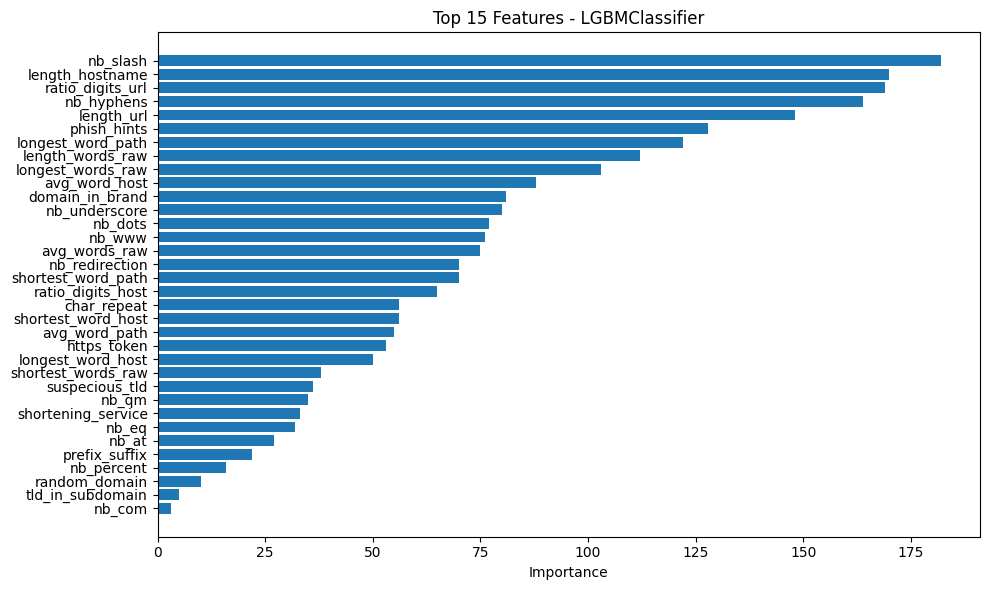

In [132]:
# Combine and visualize top 15 features from best model
if feature_importance_dfs:
    all_importances = pd.concat(feature_importance_dfs)
    
    # Get best model name
    best_model_name = results_df.iloc[0]["Model"]
    top_model_importance = all_importances[all_importances["Model"] == best_model_name]
    top_model_importance = top_model_importance.sort_values(by="Importance", ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_model_importance["Feature"], top_model_importance["Importance"])
    plt.title(f"Top 15 Features - {best_model_name}")
    plt.gca().invert_yaxis()
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print("No feature importance available for any of the models.")


In [133]:
import shap

# Refit best model (XGBClassifier) for SHAP explanations
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_scaled, y_train)


/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:06:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_scaled)


In [135]:
X_train.columns

Index(['length_url', 'length_hostname', 'nb_dots', 'nb_hyphens', 'nb_at',
       'nb_qm', 'nb_eq', 'nb_underscore', 'nb_percent', 'nb_slash', 'nb_www',
       'nb_com', 'https_token', 'ratio_digits_url', 'ratio_digits_host',
       'tld_in_subdomain', 'prefix_suffix', 'random_domain',
       'shortening_service', 'nb_redirection', 'length_words_raw',
       'char_repeat', 'shortest_words_raw', 'shortest_word_host',
       'shortest_word_path', 'longest_words_raw', 'longest_word_host',
       'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path',
       'phish_hints', 'domain_in_brand', 'suspecious_tld'],
      dtype='object')

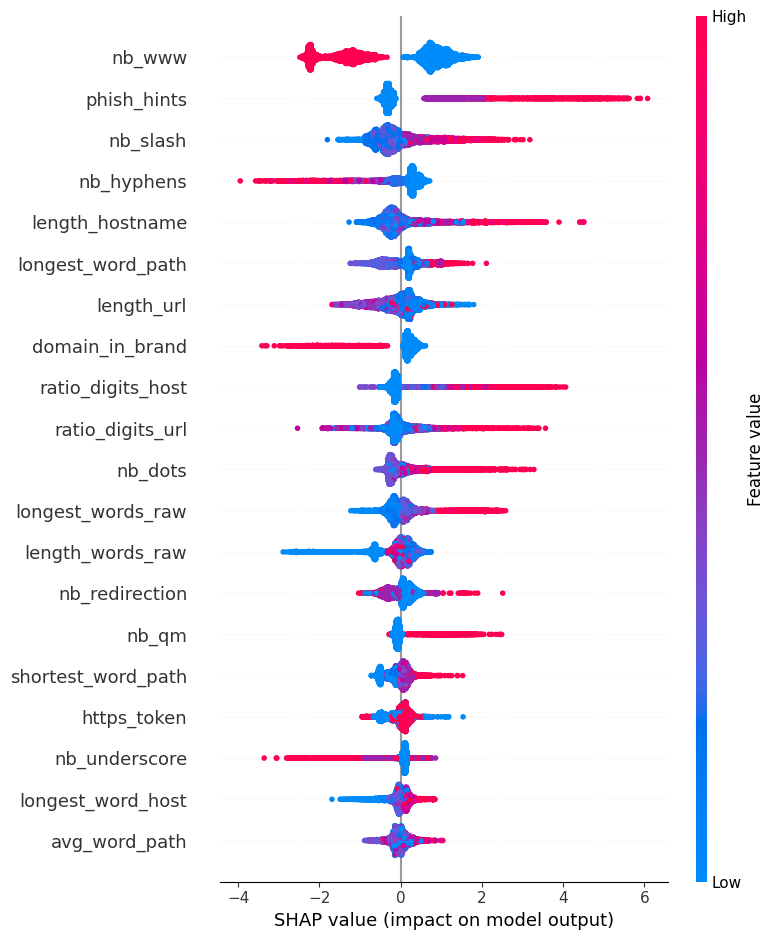

In [ ]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)


/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:27:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:27:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:27:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:27:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/astrin/.conda/envs/astrin/lib/python3.12/site-packages/xgboost

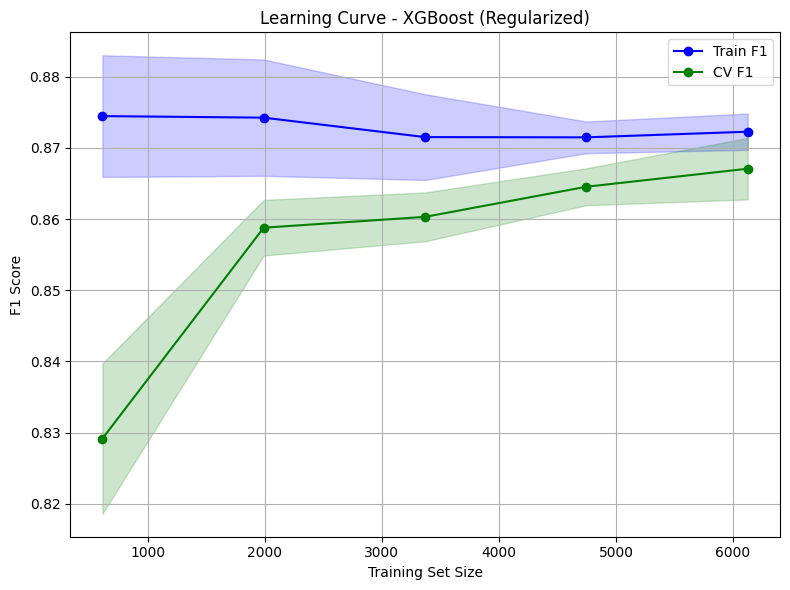

In [142]:
from sklearn.model_selection import learning_curve, StratifiedKFold
from xgboost import XGBClassifier

def plot_learning_curve(estimator, title, X, y, cv, scoring='f1'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', label="Train F1", color="blue")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
    plt.plot(train_sizes, test_mean, 'o-', label="CV F1", color="green")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="green")
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

xgb_model_regularized = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    max_depth=3,                 # פחות עומק = פחות זיכרון של train
    min_child_weight=10,         # לא לפצל על קבוצות קטנות מדי
    gamma=0.4,                   # לא לפצל אלא אם יש שיפור ממשי
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,               # L1 regularization - לקנוס תכונות מיותרות
    reg_lambda=2.0,              # L2 regularization - להימנע ממשקלים גדולים
    n_estimators=100,            # פחות עצים
    learning_rate=0.05
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(xgb_model_regularized, "Learning Curve - XGBoost (Regularized)", X_train_scaled, y_train, cv=cv)


In [141]:
import joblib

# שמירה
joblib.dump(xgb_model_regularized, "xgb_model.pkl")

# טעינה בעתיד
model_loaded = joblib.load("xgb_model.pkl")
